In [1]:
##load saved bm.keras and optimize it and then also train on test data and train data then upload final 
#default ml libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn as sk
#tf libraries
import tensorflow as tf
import tensorflow as tf
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import itertools
import pandas as pd
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, r2_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
#import kfold from sklearn
from sklearn.model_selection import KFold
from termcolor import colored
from xgboost import XGBRegressor

In [2]:
# Load the test.csv file
DEV = True
loaddata = pd.read_csv('train.csv')
testdata = pd.read_csv('test.csv')

In [3]:
train = loaddata.copy()
print(train.head())
print()
print()
print()
print()
test = testdata.copy()
print(test.head())

   id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0              

In [4]:
def categorize_age(age):
    if age <= 25:
        return 0
    elif age <= 35:
        return 0.1
    elif age <= 45:
        return 0.2
    elif age <= 55:
        return 0.3
    else:
        return 0.4
    
def categorize_income(income, quantiles):
    if income <= quantiles['q20']:
        return 0
    elif income <= quantiles['q40']:
        return 0.1
    elif income <= quantiles['q60']:
        return 0.2
    elif income <= quantiles['q80']:
        return 0.3
    else:
        return 0.4


def categorize_loan_amount(loan_amount, quantiles):
    if loan_amount <= quantiles['q20']:
        return 0
    elif loan_amount <= quantiles['q40']:
        return 1
    elif loan_amount <= quantiles['q60']:
        return 2
    elif loan_amount <= quantiles['q80']:
        return 3
    else:
        return 4

def calculate_quantiles(data, column):
    quantiles = {}
    for q in [0.2, 0.4, 0.6, 0.8]:
        quantiles[f'q{int(q*100)}'] = data[column].quantile(q)
    return quantiles
 
def categorize_loan_int_rate(rate, quantiles):
    if rate <= quantiles['q20']:
        return 0
    elif rate <= quantiles['q40']:
        return 1
    elif rate <= quantiles['q60']:
        return 2
    elif rate <= quantiles['q80']:
        return 3
    else:
        return 4

In [5]:
# feature engineering
test["loantoincome"] = ((test["loan_amnt"] / test["person_income"])).astype('Float64')
test["loan_percent_incometoincome"] = ((test["loan_percent_income"] / test["person_income"])).astype('Float64')
test['person_age_to_person_income'] = (test['person_age'] / test['person_income']).astype(str).astype('Float64')
test['person_emp_length_to_person_age'] = (test['person_emp_length'] / test['person_age']).astype('Float64')
test['loan_int_rate_to_loan_amnt'] = (test['loan_int_rate'] / test['loan_amnt']).astype('Float64')



test['income_to_age'] = test['person_income'] / test['person_age']
test['loan_to_income'] = test['loan_amnt'] / test['person_income']
test['rate_to_loan'] = test['loan_int_rate'] / test['loan_amnt']















test['log_income'] = (np.log1p(test['person_income'])).astype('Float64')
test['age_credit_history_interaction'] = (test['person_age'] * test['cb_person_cred_hist_length']).astype('float64')
test['high_loan_to_income'] = (test['loan_percent_income'] > 0.5).astype('float64')
test['is_new_credit_user'] = (test['cb_person_cred_hist_length'] < 2).astype('float64')
test['high_interest_rate'] = (test['loan_int_rate'] > test['loan_int_rate'].mean()).astype('float64')
test['loan_to_employment'] = test['loan_amnt'] / (test['person_emp_length'] + 1)
test['rate_to_grade'] = test.groupby('loan_grade')['loan_int_rate'].transform('mean')








test['age_category'] = test['person_age'].apply(categorize_age).astype('category')










test['person_home_ownership'] = test['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
test['loan_intent'] = test['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')
test['loan_grade'] = test['loan_grade'].replace({'A':6, 'B':5, 'C':4, 'D':3, 'E':2, 'F':1, 'G':0}).astype('category')
test['cb_person_default_on_file'] = test['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}).astype('category')
test["person_home_ownership_income"] = pd.Series(pd.factorize((test["person_home_ownership"].astype(str) + test["person_income"].astype(str)).to_numpy())[0]).astype('category')

test['person_home_ownership_income'].unique()

C:\Users\death\AppData\Local\Temp\ipykernel_19376\381903121.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['person_home_ownership'] = test['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
C:\Users\death\AppData\Local\Temp\ipykernel_19376\381903121.py:55: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['loan_intent'] = test['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('catego

[0, 1, 2, 3, 4, ..., 3136, 3137, 3138, 3139, 3140]
Length: 3141
Categories (3141, int64): [0, 1, 2, 3, ..., 3137, 3138, 3139, 3140]

In [6]:
#delete all files that start with lgbm and xgb 

for item in os.listdir():
    if item.startswith("lgbm") or item.startswith("xgb"):
        os.remove(item)

In [7]:
# feature engineering
train["loantoincome"] = ((train["loan_amnt"] / train["person_income"])).astype('Float64')
train["loan_percent_incometoincome"] = ((train["loan_percent_income"] / train["person_income"])).astype('Float64')
train['person_age_to_person_income'] = (train['person_age'] / train['person_income']).astype(str).astype('Float64')
train['person_emp_length_to_person_age'] = (train['person_emp_length'] / train['person_age']).astype('Float64')
train['loan_int_rate_to_loan_amnt'] = (train['loan_int_rate'] / train['loan_amnt']).astype('Float64')
train['income_to_age'] = train['person_income'] / train['person_age']
train['rate_to_loan'] = train['loan_int_rate'] / train['loan_amnt']
train['person_home_ownership'] = train['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
train['loan_intent'] = train['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')
train['loan_grade'] = train['loan_grade'].replace({'A':6, 'B':5, 'C':4, 'D':3, 'E':2, 'F':1, 'G':0}).astype('category')
train['cb_person_default_on_file'] = train['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}).astype('category')
train["person_home_ownership_income"] = pd.Series(pd.factorize((train["person_home_ownership"].astype(str) + train["person_income"].astype(str)).to_numpy())[0]).astype('category')
train['log_income'] = np.log1p(train['person_income']).astype('float64')
train['age_credit_history_interaction'] = (train['person_age'] * train['cb_person_cred_hist_length']).astype('float64')
train['high_loan_to_income'] = (train['loan_percent_income'] > 0.5).astype('float64')
train['is_new_credit_user'] = (train['cb_person_cred_hist_length'] < 2).astype('float64')
train['high_interest_rate'] = (train['loan_int_rate'] > train['loan_int_rate'].mean()).astype('float64')
train['loan_to_employment'] = (train['loan_amnt'] / (train['person_emp_length'] + 1)).astype('float64')
train['rate_to_grade'] = train.groupby('loan_grade')['loan_int_rate'].transform('mean').astype('float64')
train['age_category'] = train['person_age'].apply(categorize_age).astype('category')
train['age_to_credit_history'] = (train['person_age'] / (train['cb_person_cred_hist_length'] + 1)).astype('float64')
test['age_to_credit_history'] = (test['person_age'] / (test['cb_person_cred_hist_length'] + 1)).astype('float64')
train['income_to_loan'] = (train['person_income'] / train['loan_amnt']).astype('float64')
test['income_to_loan'] = (test['person_income'] / test['loan_amnt']).astype('float64')
train['normalized_loan_amount'] = train.groupby('loan_intent')['loan_amnt'].transform(lambda x: (x - x.mean()) / x.std()).astype('float64')
test['normalized_loan_amount'] = test.groupby('loan_intent')['loan_amnt'].transform(lambda x: (x - x.mean()) / x.std()).astype('float64')
train['log_loan_amnt'] = np.log1p(train['loan_amnt']).astype('float64')
test['log_loan_amnt'] = np.log1p(test['loan_amnt']).astype('float64')
train['income_home_mismatch'] = ((train['person_income'] > train['person_income'].quantile(0.8)) & (train['person_home_ownership'] == 0)).astype('float64')
test['income_home_mismatch'] = ((test['person_income'] > test['person_income'].quantile(0.8)) & (test['person_home_ownership'] == 0)).astype('float64')
train['default_grade_interaction'] = ((train['cb_person_default_on_file'].astype('float64')*10 +  train['loan_grade'].astype('float64'))/16).astype('category')
test['default_grade_interaction'] = ((test['cb_person_default_on_file'].astype('float64')*10 +  test['loan_grade'].astype('float64'))/16).astype('category')
train['age_interest_interaction'] = (train['person_age'].astype('float64') * train['loan_int_rate'].astype('float64')).astype('float64')   
test['age_interest_interaction'] = (test['person_age'] * test['loan_int_rate']).astype('float64')   
train['credit_history_to_age'] = (train['cb_person_cred_hist_length'].astype('float64') / train['person_age'].astype('float64')).astype('float64')
test['credit_history_to_age'] = (test['cb_person_cred_hist_length'].astype('float64') / test['person_age'].astype('float64')).astype('float64') 
train['rate_to_credit_history'] = (train['loan_int_rate'].astype('float64') / (train['cb_person_cred_hist_length'].astype('float64') + 1)).astype('float64')
test['rate_to_credit_history'] = (test['loan_int_rate'].astype('float64') / (test['cb_person_cred_hist_length'].astype('float64') + 1)).astype('float64')






























loanseventryfivequantile = train['loan_amnt'].quantile(0.75)
train['high_loan_amount'] = (train['loan_amnt'] > loanseventryfivequantile).astype('category')
test['high_loan_amount'] = (test['loan_amnt'] > loanseventryfivequantile).astype('category')


personninetyquantile = train['person_income'].quantile(0.9)
train['age_income_mismatch'] = ((train['person_age'] < 30) & (train['person_income'] > personninetyquantile)).astype('category')
test['age_income_mismatch'] = ((test['person_age'] < 30) & (test['person_income'] > personninetyquantile)).astype('category')



# Define the custom function to categorize loan interest rates
def calculate_quantiles(data, column):
    quantiles = {}
    for q in [0.2, 0.4, 0.6, 0.8]:
        quantiles[f'q{int(q*100)}'] = data[column].quantile(q)
    return quantiles
def categorize_loan_int_rate(rate, quantiles):
    if rate <= quantiles['q20']:
        return 0
    elif rate <= quantiles['q40']:
        return 1
    elif rate <= quantiles['q60']:
        return 2
    elif rate <= quantiles['q80']:
        return 3
    else:
        return 4
loan_int_rate_quantiles = calculate_quantiles(train, 'loan_int_rate')

train['loan_int_rate_category'] = train['loan_int_rate'].apply(categorize_loan_int_rate, args=(loan_int_rate_quantiles,)).astype('category')
train['default_rate_interaction'] = train['cb_person_default_on_file'].astype('float64') * 10 + train['loan_int_rate_category'].astype('float64')

test['loan_int_rate_category'] = test['loan_int_rate'].apply(categorize_loan_int_rate, args=(loan_int_rate_quantiles,)).astype('category')
test['default_rate_interaction'] = test['cb_person_default_on_file'].astype('float64') * 10 + test['loan_int_rate_category'].astype('float64')




train['intent_grade_interaction'] = (train['loan_intent'].astype('float64')*10 + train['loan_grade'].astype('float64')).astype('category')
test['intent_grade_interaction'] = (test['loan_intent'].astype('float64')*10 + test['loan_grade'].astype('float64')).astype('category')



train['home_ownership_intent'] = (train['person_home_ownership'].astype('float64')*10   + train['loan_intent'].astype('float64')).astype('category')
test['home_ownership_intent'] = (test['person_home_ownership'].astype('float64')*10   + test['loan_intent'].astype('float64')).astype('category')






loan_amount_quantiles = calculate_quantiles(train, 'loan_amnt')
train['loan_amount_category'] = train['loan_amnt'].apply(categorize_loan_amount, args=(loan_amount_quantiles,)).astype('category')
test['loan_amount_category'] = test['loan_amnt'].apply(categorize_loan_amount, args=(loan_amount_quantiles,)).astype('category')



train['risk_score'] = train['loan_percent_income'] * train['loan_int_rate'] * (6 - train['loan_grade'].astype('float64'))
test['risk_score'] = test['loan_percent_income'] * test['loan_int_rate'] * (6 - test['loan_grade'].astype('float64'))
train['loan_intent_grade'] = ((train['loan_intent'].astype('float64') * 10 + train['loan_grade'].astype('float64'))/100).astype('category')
test['loan_intent_grade'] = ((test['loan_intent'].astype('float64') * 10 + test['loan_grade'].astype('float64'))/100).astype('category')
income_quantiles = calculate_quantiles(train, 'person_income')
train['income_category'] = train['person_income'].apply(categorize_income, args=(income_quantiles,)).astype('category')
test['income_category'] = test['person_income'].apply(categorize_income, args=(income_quantiles,)).astype('category')



############################################################################################################
train['high_risk_flag'] = ((train['loan_percent_income'] > 0.4) & (train['loan_int_rate'] > train['loan_int_rate'].mean()) & (train['cb_person_default_on_file'] == 1)).astype('category')
test['high_risk_flag'] = ((test['loan_percent_income'] > 0.4) & (test['loan_int_rate'] > test['loan_int_rate'].mean()) & (test['cb_person_default_on_file'] == 1)).astype('category')

train['stability_score'] = (train['person_emp_length'] * train['person_income']) / (train['loan_amnt'] * (train['cb_person_cred_hist_length'] + 1)).astype('float64')
test['stability_score'] = (test['person_emp_length'] * test['person_income']) / (test['loan_amnt'] * (test['cb_person_cred_hist_length'] + 1)).astype('float64')

############################################################################################################






train['creditworthiness_score'] = (train['person_income'].astype('float64') / (train['loan_amnt'].astype('float64') * train['loan_int_rate'].astype('float64'))) * (train['cb_person_cred_hist_length'].astype('float64') + 1).astype('float64')
train['age_to_employment'] = (train['person_age'].astype('float64') / (train['person_emp_length'].astype('float64') + 1)).astype('float64')
train['intent_home_match'] = ((train['loan_intent'].astype('float64') == 5) & (train['person_home_ownership'].astype('float64') == 2)).astype('float64')
train['normalized_income'] = train.groupby('age_category')['person_income'].transform(lambda x: ((x.astype('float64') - x.mean().astype('float64')) / x.std().astype('float64'))).astype('float64')
train['rate_to_age'] = (train['loan_int_rate'].astype('float64') / train['person_age'].astype('float64')).astype('float64')
test['creditworthiness_score'] = (test['person_income'].astype('float64') / (test['loan_amnt'].astype('float64') * test['loan_int_rate'].astype('float64'))) * (test['cb_person_cred_hist_length'].astype('float64') + 1).astype('float64')
test['age_to_employment'] = (test['person_age'].astype('float64') / (test['person_emp_length'].astype('float64') + 1)).astype('float64')
test['intent_home_match'] = ((test['loan_intent'].astype('float64') == 5) & (test['person_home_ownership'].astype('float64') == 2)).astype('float64')
test['normalized_income'] = test.groupby('age_category')['person_income'].transform(lambda x: ((x.astype('float64') - x.mean().astype('float64')) / x.std().astype('float64'))).astype('float64')
test['rate_to_age'] = (test['loan_int_rate'].astype('float64') / test['person_age'].astype('float64')).astype('float64')






train['home_ownership_loan_interaction'] = (train['person_home_ownership'].astype('float64')*10  + train['loan_amount_category'].astype('float64')).astype('category')
test['home_ownership_loan_interaction'] = (test['person_home_ownership'].astype('float64')*10  + test['loan_amount_category'].astype('float64')).astype('category')


# more feature engineering

train['loan_intent_grade'].unique()


C:\Users\death\AppData\Local\Temp\ipykernel_19376\1823741811.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['person_home_ownership'] = train['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
C:\Users\death\AppData\Local\Temp\ipykernel_19376\1823741811.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['loan_intent'] = train['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('c

[0.05, 0.14, 0.26, 0.35, 0.16, ..., 0.1, 0.5, 0.2, 0.0, 0.4]
Length: 42
Categories (42, float64): [0.00, 0.01, 0.02, 0.03, ..., 0.53, 0.54, 0.55, 0.56]

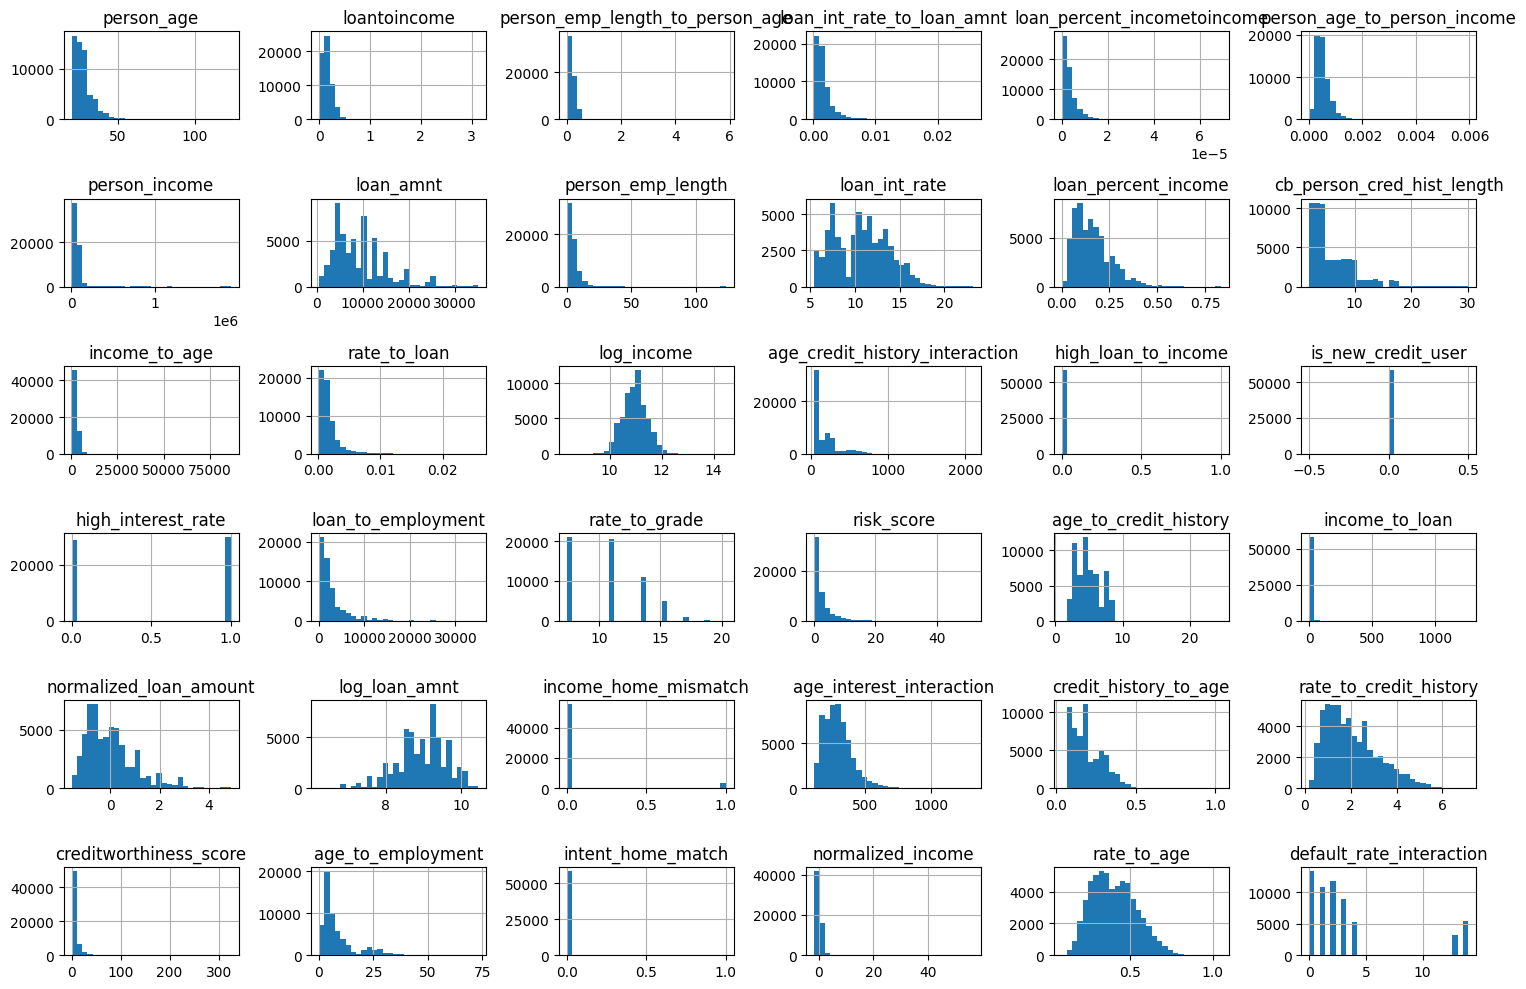

loan_status
0    50295
1     8350
Name: count, dtype: int64
loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64

person_home_ownership: 4 unique values
loan_intent: 6 unique values
loan_grade: 7 unique values
cb_person_default_on_file: 2 unique values
person_home_ownership_income: 3899 unique values
age_category: 5 unique values
loan_intent_grade: 42 unique values
income_category: 5 unique values
default_grade_interaction: 14 unique values
loan_amount_category: 5 unique values
age_income_mismatch: 2 unique values
high_loan_amount: 2 unique values
home_ownership_loan_interaction: 20 unique values
loan_int_rate_category: 5 unique values
intent_grade_interaction: 42 unique values
home_ownership_intent: 24 unique values
total unique values in categorical columns: 4084


In [8]:
# train['creditworthiness_score'] = (train['person_income'].astype('float64') / (train['loan_amnt'].astype('float64') * train['loan_int_rate'].astype('float64'))) * (train['cb_person_cred_hist_length'].astype('float64') + 1).astype('float64')
# train['age_to_employment'] = (train['person_age'].astype('float64') / (train['person_emp_length'].astype('float64') + 1)).astype('float64')
# train['intent_home_match'] = ((train['loan_intent'].astype('float64') == 5) & (train['person_home_ownership'].astype('float64') == 2)).astype('float64')
# train['normalized_income'] = train.groupby('age_category')['person_income'].transform(lambda x: ((x.astype('float64') - x.mean().astype('float64')) / x.std().astype('float64'))).astype('float64')
# train['rate_to_age'] = (train['loan_int_rate'].astype('float64') / train['person_age'].astype('float64')).astype('float64')
# train['risk_score'] = train['loan_percent_income'] * train['loan_int_rate'] * (6 - train['loan_grade'].astype('float64'))
# train['loan_intent_grade'] = ((train['loan_intent'].astype('float64') * 10 + train['loan_grade'].astype('float64'))/100).astype('category')
# train['income_category'] = train['person_income'].apply(categorize_income, args=(income_quantiles,)).astype('category')
# train['age_interest_interaction'] = (train['person_age'].astype('float64') * train['loan_int_rate'].astype('float64')).astype('float64')   
# train['credit_history_to_age'] = (train['cb_person_cred_hist_length'].astype('float64') / train['person_age'].astype('float64')).astype('float64')
# train['rate_to_credit_history'] = (train['loan_int_rate'].astype('float64') / (train['cb_person_cred_hist_length'].astype('float64') + 1)).astype('float64')
# train["loantoincome"] = ((train["loan_amnt"] / train["person_income"])).astype('Float64')
# train["loan_percent_incometoincome"] = ((train["loan_percent_income"] / train["person_income"])).astype('Float64')
# train['person_age_to_person_income'] = (train['person_age'] / train['person_income']).astype(str).astype('Float64')
# train['person_emp_length_to_person_age'] = (train['person_emp_length'] / train['person_age']).astype('Float64')
# train['loan_int_rate_to_loan_amnt'] = (train['loan_int_rate'] / train['loan_amnt']).astype('Float64')
# train['income_to_age'] = train['person_income'] / train['person_age']
# train['rate_to_loan'] = train['loan_int_rate'] / train['loan_amnt']
# train['person_home_ownership'] = train['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
# train['loan_intent'] = train['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')
# train['loan_grade'] = train['loan_grade'].replace({'A':6, 'B':5, 'C':4, 'D':3, 'E':2, 'F':1, 'G':0}).astype('category')
# train['cb_person_default_on_file'] = train['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}).astype('category')
# train["person_home_ownership_income"] = pd.Series(pd.factorize((train["person_home_ownership"].astype(str) + train["person_income"].astype(str)).to_numpy())[0]).astype('category')
# train['log_income'] = np.log1p(train['person_income']).astype('float64')
# train['age_credit_history_interaction'] = (train['person_age'] * train['cb_person_cred_hist_length']).astype('float64')
# train['high_loan_to_income'] = (train['loan_percent_income'] > 0.5).astype('float64')
# train['is_new_credit_user'] = (train['cb_person_cred_hist_length'] < 2).astype('float64')
# train['high_interest_rate'] = (train['loan_int_rate'] > train['loan_int_rate'].mean()).astype('float64')
# train['loan_to_employment'] = (train['loan_amnt'] / (train['person_emp_length'] + 1)).astype('float64')
# train['rate_to_grade'] = train.groupby('loan_grade')['loan_int_rate'].transform('mean').astype('float64')
# train['age_category'] = train['person_age'].apply(categorize_age).astype('category')
# train['age_to_credit_history'] = (train['person_age'] / (train['cb_person_cred_hist_length'] + 1)).astype('float64')
# train['income_to_loan'] = (train['person_income'] / train['loan_amnt']).astype('float64')
# train['normalized_loan_amount'] = train.groupby('loan_intent')['loan_amnt'].transform(lambda x: (x - x.mean()) / x.std()).astype('float64')
# train['log_loan_amnt'] = np.log1p(train['loan_amnt']).astype('float64')
# train['income_home_mismatch'] = ((train['person_income'] > train['person_income'].quantile(0.8)) & (train['person_home_ownership'] == 0)).astype('float64')
# train['default_grade_interaction'] = ((train['cb_person_default_on_file'].astype('float64')*10 +  train['loan_grade'].astype('float64'))/16).astype('category')


# Plot histograms for numerical columns
numerical_columns = ['person_age','loantoincome','person_emp_length_to_person_age',
                     'loan_int_rate_to_loan_amnt','loan_percent_incometoincome',
                     'person_age_to_person_income','person_income', 'loan_amnt',"person_emp_length" ,
                     'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length','income_to_age','rate_to_loan','log_income',
                     'age_credit_history_interaction','high_loan_to_income','is_new_credit_user','high_interest_rate','loan_to_employment','rate_to_grade',
                     'risk_score','age_to_credit_history','income_to_loan','normalized_loan_amount','log_loan_amnt','income_home_mismatch',
                     'age_interest_interaction','credit_history_to_age','rate_to_credit_history',
                     'creditworthiness_score','age_to_employment','intent_home_match','normalized_income','rate_to_age',
                     'default_rate_interaction'
                     ]
train[numerical_columns].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Plot count plots for categorical columns
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'loan_status',
    "person_home_ownership_income",
    'age_category',
    'loan_intent_grade',
    'income_category',
    'default_grade_interaction',
    'loan_amount_category',
    'age_income_mismatch',
    'high_loan_amount',
    'home_ownership_loan_interaction',
    'loan_int_rate_category',
    'intent_grade_interaction',
    'home_ownership_intent',
]
if  not  DEV:
    fig, axes = plt.subplots(math.ceil(len(categorical_columns)/2)+1, 2, figsize=(15, 15))  # Adjusted to 3x2 grid
    for ax, col in zip(axes.flatten(), categorical_columns):
        sns.countplot(data=train, x=col, ax=ax)
        ax.set_title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
categorical_columns.remove('loan_status')
numerical_features = numerical_columns
categorical_features = categorical_columns

features = numerical_columns + categorical_columns 
# features.remove('loan_status')
# Define the preprocessing for numerical and categorical features
#print how many 'load_status' 0 and 1 and find the ratio
print(train['loan_status'].value_counts())
print(train['loan_status'].value_counts(normalize=True))
print()
p = 0 
for col in categorical_columns:
    unique_values = train[col].nunique()
    print(f"{col}: {unique_values} unique values")
    p+=unique_values
print(f'total unique values in categorical columns: {p}')


In [9]:
# print(train.head(4))
#print all the columns
pd.set_option('display.max_columns', None)
print(train.shape)
train.head(4)

(58645, 56)


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loantoincome,loan_percent_incometoincome,person_age_to_person_income,person_emp_length_to_person_age,loan_int_rate_to_loan_amnt,income_to_age,rate_to_loan,person_home_ownership_income,log_income,age_credit_history_interaction,high_loan_to_income,is_new_credit_user,high_interest_rate,loan_to_employment,rate_to_grade,age_category,age_to_credit_history,income_to_loan,normalized_loan_amount,log_loan_amnt,income_home_mismatch,default_grade_interaction,age_interest_interaction,credit_history_to_age,rate_to_credit_history,high_loan_amount,age_income_mismatch,loan_int_rate_category,default_rate_interaction,intent_grade_interaction,home_ownership_intent,loan_amount_category,risk_score,loan_intent_grade,income_category,high_risk_flag,stability_score,creditworthiness_score,age_to_employment,intent_home_match,normalized_income,rate_to_age,home_ownership_loan_interaction
0,0,37,35000,0,0.0,0,5,6000,11.49,0.17,0,14,0,0.171429,0.000005,0.001057,0.0,0.001915,945.945946,0.001915,0,10.463132,518.0,0.0,0.0,1.0,6000.000000,11.034733,0.2,2.466667,5.833333,-0.558667,8.699681,0.0,0.3125,425.13,0.378378,0.766000,False,False,2,2.0,5.0,0.0,1,1.9533,0.05,0.0,False,0.000000,7.615318,37.000000,0.0,-0.838998,0.310541,1.0
1,1,22,56000,2,6.0,1,4,4000,13.35,0.07,0,2,0,0.071429,0.000001,0.000393,0.272727,0.003337,2545.454545,0.003337,1,10.933125,44.0,0.0,0.0,1.0,571.428571,13.510343,0.0,7.333333,14.000000,-0.896247,8.294300,0.0,0.2500,293.70,0.090909,4.450000,False,False,3,3.0,14.0,21.0,0,1.8690,0.14,0.2,False,28.000000,3.146067,3.142857,0.0,-0.107897,0.606818,20.0
2,2,29,28800,2,8.0,2,6,6000,8.90,0.21,0,10,0,0.208333,0.000007,0.001007,0.275862,0.001483,993.103448,0.001483,2,10.268165,290.0,0.0,0.0,0.0,666.666667,7.335176,0.1,2.636364,4.800000,-0.584460,8.699681,0.0,0.3750,258.10,0.344828,0.809091,False,False,1,1.0,26.0,22.0,1,0.0000,0.26,0.0,False,3.490909,5.932584,3.222222,0.0,-0.928901,0.306897,21.0
3,3,30,70000,0,14.0,3,5,12000,11.11,0.17,0,5,0,0.171429,0.000002,0.000429,0.466667,0.000926,2333.333333,0.000926,3,11.156265,150.0,0.0,0.0,1.0,800.000000,11.034733,0.1,5.000000,5.833333,0.492919,9.392745,0.0,0.3125,333.30,0.166667,1.851667,False,False,2,2.0,35.0,3.0,3,1.8887,0.35,0.3,False,13.611111,3.150315,2.000000,0.0,0.046948,0.370333,3.0


In [10]:
features

['person_age',
 'loantoincome',
 'person_emp_length_to_person_age',
 'loan_int_rate_to_loan_amnt',
 'loan_percent_incometoincome',
 'person_age_to_person_income',
 'person_income',
 'loan_amnt',
 'person_emp_length',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'income_to_age',
 'rate_to_loan',
 'log_income',
 'age_credit_history_interaction',
 'high_loan_to_income',
 'is_new_credit_user',
 'high_interest_rate',
 'loan_to_employment',
 'rate_to_grade',
 'risk_score',
 'age_to_credit_history',
 'income_to_loan',
 'normalized_loan_amount',
 'log_loan_amnt',
 'income_home_mismatch',
 'age_interest_interaction',
 'credit_history_to_age',
 'rate_to_credit_history',
 'creditworthiness_score',
 'age_to_employment',
 'intent_home_match',
 'normalized_income',
 'rate_to_age',
 'default_rate_interaction',
 'person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file',
 'person_home_ownership_income',
 'age_category',
 'loan_intent_grade',
 'inc

In [11]:
# import pandas as pd
# import hashlib

# def hashing_encode(df, cols, num_features=5000):
#     for col in cols:
#         # Hash the values into 'num_features' bins
#         df[f'{col}_hash'] = df[col].apply(lambda x: int(hashlib.md5(str(x).encode('utf-8')).hexdigest(), 16) % num_features)
    
#     return df

# # Example usage
# # df = pd.DataFrame({'color': ['red', 'blue', 'green']})
# # hashing_encode(df, ['color'], num_features=500)
# # print(df)


# hashing_encode(train, categorical_columns)
# hashing_encode(test, categorical_columns)
# # train.shape

In [12]:
# Split the data into training and testing sets



target = ['loan_status']  # Replace with the actual target column name

# Preprocess the data
X = train[features]
y = train[target]
ids = train['id']
testx = test[features]
test_ids = test['id']

X.shape , y.shape , testx.shape,  test_ids.shape
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, ids, test_size=0.2, random_state=42)
print(f'dtype of X_train: {X_train.dtypes} dtype of X IS {X.dtypes}')
# Define the preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
# XTR = preprocessor.fit_transform(X_train)
# XTE = preprocessor.transform(X_test)
# TEX = preprocessor.transform(testx)
# X_train = XTR
# X_test = XTE
# testx = TEX
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
testx = preprocessor.transform(testx)

# Function to add noise
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

# Add noise to the numerical features
X_train_noisy = X_train.copy()
X_test_noisy = X_test.copy()
X_train_noisy[:, :len(numerical_features)] = add_noise(X_train[:, :len(numerical_features)])
X_test_noisy[:, :len(numerical_features)] = add_noise(X_test[:, :len(numerical_features)])


X_train_less_noise = X_train.copy()
X_test_less_noise = X_test.copy()
X_train_less_noise[:, :len(numerical_features)] = add_noise(X_train[:, :len(numerical_features)],noise_level=0.001)
X_test_less_noise[:, :len(numerical_features)] = add_noise(X_test[:, :len(numerical_features)],noise_level=0.001)

# Concatenate the original data with the noisy data vertically
X_train_combined = np.vstack((X_train, X_train_noisy, X_train_less_noise))
X_test_combined = np.vstack((X_test, X_test_noisy, X_test_less_noise))

# Concatenate the target variable as well
y_train_combined = np.vstack((y_train, y_train, y_train))
y_test_combined = np.vstack((y_test, y_test,y_test))

# Concatenate the ids as well
ids_train_combined = np.hstack((ids_train, ids_train, ids_train))
ids_test_combined = np.hstack((ids_test, ids_test, ids_test))

# Update the original variables
X_train = X_train_combined
X_test = X_test_combined
y_train = y_train_combined
y_test = y_test_combined
ids_train = ids_train_combined
ids_test = ids_test_combined
xult , yult  , idsult= np.vstack((X_train, X_test)), np.vstack((y_train, y_test)) , np.hstack((ids_train, ids_test))
print(X_train.shape)  # Should output (46916 + 46916, 26)
print(X_test.shape)   # Should output (11729 + 11729, 26)
print(y_train.shape)  # Should output (46916 + 46916, 1)
print(y_test.shape)   # Should output (11729 + 11729, 1)
print(ids_train.shape)  # Should output (46916 + 46916,)
print(ids_test.shape)   # Should output (11729 + 11729,)
print(testx.shape)   # Should output (11729 + 11729,)
print(test_ids.shape)   # Should output (11729 + 11729,)


dtype of X_train: person_age                            int64
loantoincome                        Float64
person_emp_length_to_person_age     Float64
loan_int_rate_to_loan_amnt          Float64
loan_percent_incometoincome         Float64
person_age_to_person_income         Float64
person_income                         int64
loan_amnt                             int64
person_emp_length                   float64
loan_int_rate                       float64
loan_percent_income                 float64
cb_person_cred_hist_length            int64
income_to_age                       float64
rate_to_loan                        float64
log_income                          float64
age_credit_history_interaction      float64
high_loan_to_income                 float64
is_new_credit_user                  float64
high_interest_rate                  float64
loan_to_employment                  float64
rate_to_grade                       float64
risk_score                          float64
age_to_credit_

In [13]:
def fmax(value=False):
    if(value):
        try:
            with open("fmax.txt", "w") as f:
                f.write(str(value))
            return 0    
        except:
            return 0
    try:
        with open("fmax.txt", "r") as f:
            return float(f.read())
    except:
        return 0


In [14]:

class ensemble:
    def __init__(self):
        self.models = []
        
    def add_model(self, model):
        self.models.append(model)
        
    def predict(self, X_test):
        predictions = []
        for model in self.models:
            pred = model.predict(X_test)
            predictions.append(pred)
            count_greater_than_0_5 = (pred > model.THRESHOLD).sum()
            count_less_than_or_equal_0_5 = (pred <= model.THRESHOLD).sum()
            print(f'Percentage of predictions greater than {model.THRESHOLD}: {count_greater_than_0_5 / len(pred) * 100:.2f}%')
            passc = count_greater_than_0_5 / len(pred) * 100
            if passc < 5:
                predictions.pop()
                continue
            print(f'Percentage of predictions less than or equal to {model.THRESHOLD}: {count_less_than_or_equal_0_5 / len(pred) * 100:.2f}%')
        
        # Stack predictions to form a 2D array
        stacked_predictions = np.hstack(predictions)
        
        # Average the predictions across models
        y_pred = np.mean(stacked_predictions, axis=1)
        
        # Apply threshold
        # y_pred = (y_pred > 0.5).astype(int)
        
        # Flatten the predictions to form a 1D array
        y_pred = y_pred.flatten()
        
        # Assuming test_ids is defined elsewhere in your code
        ids = test_ids
        predictions_df = pd.DataFrame({'id': ids, 'loan_status': y_pred})
        return predictions_df
    
    def save(self, testx, path="ftt.csv"):
        df = self.predict(testx)
        df.to_csv(path, index=False,float_format='%.18f')
        csvfile =  pd.read_csv(path)
        csvfile
        
    def rmamodel(self):
        self.models = []

ens = ensemble()

In [15]:
def ktrain( model , xult , yult,splits=5,epochs=15,batch_size=32,random_state=42):
    
    if splits==1:
        class temp:
            def split(self, X):
                n_samples = len(X)
                indices = list(range(n_samples))
                yield indices, indices  # Use the same indices for train and test

        kf = temp()
    else:
        kf = KFold(n_splits=splits, shuffle=True, random_state=random_state)
        obj = kf 
    losses, aucs, precisions, recalls, f1s, roc_aucs , mses ,r2s= [], [], [], [], [], [],[],[]
    iter = 0
    for train_index, test_index in kf.split(X):
        xt, xv = xult[train_index], xult[test_index]
        yt, yv = yult[train_index], yult[test_index]
        
        # Initialize and compile the model
        
        # Train the model
        model.fit(xt, yt, epochs=epochs, batch_size=batch_size, verbose=1)
        
        # Evaluate the model
        results = model.evaluate(xv, yv)
        if isinstance(model, XGBoostRegressorModel) or isinstance(model, XGBoostRegressorModel2):
            mse , r2 , f1 , precision , recall , auc = results[0], results[1], results[2], results[3], results[4] , results[5]
            mses.append(mse)
            r2s.append(r2)
        else:
            loss, auc, precision, recall = results[0], results[1], results[2], results[3]
            losses.append(loss)
        
        # Predict probabilities for the test set
        y_pred_prob = model.predict(xult)
        y_pred = (y_pred_prob > model.THRESHOLD).astype(int)
        
        # Calculate F1 score and ROC AUC score
        f1 = f1_score(yult, y_pred)
        #count which iteration is this
        count = train_index[0]
        roc_auc = roc_auc_score(yult, y_pred_prob)
        if f1 > fmax():
            model.f1max(iter,epochs,splits)
            fmax(f1)
            model.save('best.keras')
            print(colored(f'F1 Score improved to {f1}. Saving model...', 'green','on_red'))
        # Store metrics
        aucs.append(auc)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        roc_aucs.append(roc_auc)
        iter += 1
    print('losses: ', losses)
    print('aucs: ', aucs)
    print('precisions: ', precisions)
    print('recalls: ', recalls)
    print('f1s: ', f1s)
    print('roc_aucs: ', roc_aucs)
    if not isinstance(model, XGBoostRegressorModel) or isinstance(model, XGBoostRegressorModel2):
        try:
            print(f'Average Loss: {sum(losses) / len(losses)}')
        except:
            pass
    else:
        print(f'Average MSE: {sum(mses) / len(mses)}')
        print(f'Average R2: {sum(r2s) / len(r2s)}')
        # try:
        # except:
        #     pass
    try:
        print(f'Average AUC: {sum(aucs) / len(aucs)}')
        print(f'Average Precision: {sum(precisions) / len(precisions)}')
        print(f'Average Recall: {sum(recalls) / len(recalls)}')
        print(f'Average F1 Score: {sum(f1s) / len(f1s)}')
        print(f'Average ROC AUC Score: {sum(roc_aucs) / len(roc_aucs)}')
    except:
        pass
    if  isinstance(model, XGBoostRegressorModel) or isinstance(model, XGBoostRegressorModel2):
        return mses,r2s
    else:
        return losses, aucs, precisions, recalls, f1s, roc_aucs
        #print typeof mses 
        # print(f'len mses : {len(mses)}')
        # print(f'typeof mses : {type(mses)}')


In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, precision_score, recall_score, roc_auc_score

class XGBoostRegressorModel:
    def __init__(self, eval_metric='rmse', model_path='xgbr_model.json', **kwargs):
        self.model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric=eval_metric, **kwargs)
        self.model_path = model_path
        self.load_model()
        self.THRESHOLD = 0.5    

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        self.model.fit(X_train, y_train, verbose=verbose, xgb_model=self.model_path if self.model_exists() else None)
        self.save_model()

    def predict(self, X_test):
        print('Predicting using XGBoost model')
        return self.model.predict(X_test).reshape(-1, 1)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Binarize or categorize the regression outputs for precision, recall, F1 score, and ROC AUC score calculation
        y_pred_binarized = (y_pred > y_test.mean()).astype(int)
        y_test_binarized = (y_test > y_test.mean()).astype(int)
        
        f1 = f1_score(y_test_binarized, y_pred_binarized)
        precision = precision_score(y_test_binarized, y_pred_binarized)
        recall = recall_score(y_test_binarized, y_pred_binarized)
        roc_auc = roc_auc_score(y_test_binarized, y_pred)
        
        return [mse, r2, f1, precision, recall, roc_auc]

    def summary(self):
        print(self.model)

    def save_model(self):
        self.model.save_model(self.model_path)

    def load_model(self):
        if self.model_exists():
            self.model.load_model(self.model_path)

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False

    def save(self, path):
        self.model.save_model(path)

# # Example usage
# # Assuming X and y are your feature matrix and target vector
# # Split the data into training and test sets
# mses,r2s= [],[]

# for i in range(9):
#     model_path = ""
#     if i % 2 == 0:
#         model_path = "xgbr_modelr.json"
#         xgb_model = XGBoostRegressorModel(eval_metric='rmse', model_path=model_path)
#     else:
#         model_path = "xgbr_modelm.json"
#         xgb_model = XGBoostRegressorModel(eval_metric='mae', model_path=model_path)
#     mse,r2 = ktrain(xgb_model, xult, yult,  splits=5, random_state=i )
#     for x in range( len(mse)):
#         mses.append(mse)
#         if x < min(mse):
#             print(f'min mse at {x}th iteration and model is {model_path} and iter is {i}')
#     for y in range( len(r2)):
#         r2s.append(r2)
#         if y < max(r2):
#             print(f'max r2 at {y}th iteration and model is {model_path} and iter is {i}')
       
        
#     ens.add_model(xgb_model)


In [292]:
# import plotly.graph_objs as go
# import plotly.io as pio

# # Assuming mses and r2s are lists of lists
# mses_flat = [item for sublist in mses for item in sublist]
# r2s_flat = [item for sublist in r2s for item in sublist]

# # Create the MSE plot
# mse_trace = go.Scatter(
#     x=list(range(1, len(mses_flat) + 1)),
#     y=mses_flat,
#     mode='lines+markers+text',
#     text=[f'({i}, {mse:.2f})' for i, mse in enumerate(mses_flat, start=1)],
#     textposition='top center',
#     marker=dict(color='blue'),
#     name='MSE'
# )

# mse_layout = go.Layout(
#     title='Iteration vs MSE',
#     xaxis=dict(title='Iteration'),
#     yaxis=dict(title='MSE'),
#     hovermode='closest'
# )

# mse_fig = go.Figure(data=[mse_trace], layout=mse_layout)

# # Create the R² plot
# r2_trace = go.Scatter(
#     x=list(range(1, len(r2s_flat) + 1)),
#     y=r2s_flat,
#     mode='lines+markers+text',
#     text=[f'({i}, {r2:.2f})' for i, r2 in enumerate(r2s_flat, start=1)],
#     textposition='top center',
#     marker=dict(color='green'),
#     name='R²'
# )

# r2_layout = go.Layout(
#     title='Iteration vs R²',
#     xaxis=dict(title='Iteration'),
#     yaxis=dict(title='R²'),
#     hovermode='closest'
# )

# r2_fig = go.Figure(data=[r2_trace], layout=r2_layout)

# # Show the plots
# pio.show(mse_fig)
# pio.show(r2_fig)

In [293]:
# # print index of min of mses array
# print(mses.index(min(mses)))
# # print index of min of r2s array
# print(r2s.index(max(r2s)))
# print(min(mses))
# print(max(r2s))

In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, precision_score, recall_score, roc_auc_score

class XGBoostRegressorModel2:
    def __init__(self, eval_metric='rmse', model_path='xgbr_model.json', **kwargs):
        self.model = xgb.XGBRegressor(objective='reg:logistic', eval_metric=eval_metric, **kwargs)
        self.model_path = model_path
        self.load_model()
        self.THRESHOLD = 0.5    

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        self.model.fit(X_train, y_train, verbose=verbose, xgb_model=self.model_path if self.model_exists() else None)
        self.save_model()

    def predict(self, X_test):
        # print('Predicting using XGBoost model')
        return self.model.predict(X_test).reshape(-1, 1)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Binarize or categorize the regression outputs for precision, recall, F1 score, and ROC AUC score calculation
        y_pred_binarized = (y_pred > y_test.mean()).astype(int)
        y_test_binarized = (y_test > y_test.mean()).astype(int)
        
        f1 = f1_score(y_test_binarized, y_pred_binarized)
        precision = precision_score(y_test_binarized, y_pred_binarized)
        recall = recall_score(y_test_binarized, y_pred_binarized)
        roc_auc = roc_auc_score(y_test_binarized, y_pred)
        
        return [mse, r2, f1, precision, recall, roc_auc]

    def summary(self):
        print(self.model)

    def save_model(self):
        self.model.save_model(self.model_path)

    def load_model(self):
        if self.model_exists():
            self.model.load_model(self.model_path)

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False

    def save(self, path):
        self.model.save_model(path)
 
# mses,r2s= [],[]

d,k = False , False
for i in range(9):
    model_path = ""
    if i % 2 == 0:
        model_path = "xgbr_modelrrr.json"
        xgb_model = XGBoostRegressorModel2(eval_metric='rmse', model_path=model_path)
    else:
        model_path = "xgbr_modelmmm.json"
        xgb_model = XGBoostRegressorModel2(eval_metric='mae', model_path=model_path)
    mse,r2 = ktrain(xgb_model, xult, yult,  splits=5, random_state=i )
    # print(len(mses))
    # print(len(r2s))
    # for x in mse:
    #     if(len(mses)!=0):
    #         if (x < min(mses)):
    #             print(colored(f'min mse at {x}th iteration and model is {model_path} and iter is {i}', 'green','on_red'))
    #     mses.append(x)
            
    # for y in r2:
    #     if(len(r2s)!=0):
    #         if (y < min(r2s)):
    #             print(colored(f'min mse at nano {x}th iteration and model is {model_path} and iter is {i}', 'red','on_green'))
    #     r2s.append(y)
    ens.add_model(xgb_model)


In [295]:
# import plotly.graph_objs as go
# import plotly.io as pio

# # Assuming mses and r2s are lists of lists
# mses_flat = [item for sublist in mses for item in sublist]
# r2s_flat = [item for sublist in r2s for item in sublist]

# # Create the MSE plot
# mse_trace = go.Scatter(
#     x=list(range(1, len(mses_flat) + 1)),
#     y=mses_flat,
#     mode='lines+markers+text',
#     text=[f'({i}, {mse:.2f})' for i, mse in enumerate(mses_flat, start=1)],
#     textposition='top center',
#     marker=dict(color='blue'),
#     name='MSE'
# )

# mse_layout = go.Layout(
#     title='Iteration vs MSE',
#     xaxis=dict(title='Iteration'),
#     yaxis=dict(title='MSE'),
#     hovermode='closest'
# )

# mse_fig = go.Figure(data=[mse_trace], layout=mse_layout)

# # Create the R² plot
# r2_trace = go.Scatter(
#     x=list(range(1, len(r2s_flat) + 1)),
#     y=r2s_flat,
#     mode='lines+markers+text',
#     text=[f'({i}, {r2:.2f})' for i, r2 in enumerate(r2s_flat, start=1)],
#     textposition='top center',
#     marker=dict(color='green'),
#     name='R²'
# )

# r2_layout = go.Layout(
#     title='Iteration vs R²',
#     xaxis=dict(title='Iteration'),
#     yaxis=dict(title='R²'),
#     hovermode='closest'
# )

# r2_fig = go.Figure(data=[r2_trace], layout=r2_layout)

# # Show the plots
# pio.show(mse_fig)
# pio.show(r2_fig)

In [296]:
# # print index of min of mses array
# print(mses.index(min(mses)))
# # print index of min of r2s array
# print(r2s.index(max(r2s)))
# print(min(mses))
# print(max(r2s))

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

class XGBoostClassifierModel:
    def __init__(self, eval_metric='logloss', model_path='xgb_model.json', **kwargs):
        self.model = xgb.XGBClassifier(objective='binary:logistic', eval_metric=eval_metric, **kwargs)
        self.model_path = model_path
        self.THRESHOLD = 0.5
        self.load_model()
        self.f1 = 0 # Placeholder for F1 score

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        self.model.fit(X_train, y_train, verbose=verbose, xgb_model=self.model_path if self.model_exists() else None)
        self.save_model()

    def predict(self, X_test):
        print(colored('predicting using xgboost model', 'green'))
        return self.model.predict(X_test).reshape(-1, 1)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        # Assuming loss is not directly available, using log loss as a proxy
        loss = -1  # Placeholder, as XGBoost does not directly provide loss in this context
        return [loss, auc, precision, recall]

    def summary(self):
        print(self.model)
    def f1max(self, *args, **kwargs):
        print(self.summary())
        if args:
            print(f"iter: {args[0]}, epochs: {args[1]}, splits: {args[2]}")
        print(kwargs)
    def save_model(self):
        self.model.save_model(self.model_path)

    def load_model(self):
        if self.model_exists():
            self.model.load_model(self.model_path)

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False
    def save(self, path):
        self.model.save_model(path)

# Example usage
# Assuming xult and yult are your feature matrix and target vector
# Split the data into training and test sets
losses, aucs, precisions, recalls, f1s, roc_aucs = [], [], [], [], [], []
for i in range(9):
    model_path = ""
    if i%2==0:
        model_path = 'xgb_modell.json'
        xgb_model = XGBoostClassifierModel(eval_metric='logloss' , model_path=model_path)
    else:
        model_path = 'xgb_modela.json'
        xgb_model = XGBoostClassifierModel(eval_metric='auc', model_path=model_path)
    losse, auc, precision, recall, f1, roc_auc = ktrain(xgb_model, xult, yult, epochs=10, batch_size=32, splits=5, random_state=i)
    losses.append(losse)
    aucs.append(auc)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    roc_aucs.append(roc_auc)
    
    ens.add_model(xgb_model)

In [298]:
# print(len(losses))
# print(len(aucs))
# print(len(precisions))
# print(len(recalls))
# print(len(f1s))

20
20
20
20
20


In [299]:
# import plotly.graph_objs as go
# import plotly.io as pio

# # Assuming losses, aucs, precisions, recalls, f1s, and roc_aucs are lists of lists
# metrics = {
#     'Losses': losses,
#     'AUCs': aucs,
#     'Precisions': precisions,
#     'Recalls': recalls,
#     'F1s': f1s,
#     'ROC AUCs': roc_aucs
# }

# colors = {
#     'Losses': 'blue',
#     'AUCs': 'green',
#     'Precisions': 'red',
#     'Recalls': 'purple',
#     'F1s': 'orange',
#     'ROC AUCs': 'brown'
# }

# for metric_name, metric_values in metrics.items():
#     metric_flat = [item for sublist in metric_values for item in sublist]
    
#     trace = go.Scatter(
#         x=list(range(1, len(metric_flat) + 1)),
#         y=metric_flat,
#         mode='lines+markers+text',
#         text=[f'({i}, {value:.2f})' for i, value in enumerate(metric_flat, start=1)],
#         textposition='top center',
#         marker=dict(color=colors[metric_name]),
#         name=metric_name
#     )
    
#     layout = go.Layout(
#         title=f'Iteration vs {metric_name}',
#         xaxis=dict(title='Iteration'),
#         yaxis=dict(title=metric_name),
#         hovermode='closest'
#     )
    
#     fig = go.Figure(data=[trace], layout=layout)
    
#     # Show the plot
#     pio.show(fig)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from colorama import init
from termcolor import colored
# Define the L2 regularizers


k = .0001
kernel_regularizer = l2(0.0001*k)
bias_regularizer = l2(0.00001*k)

# Define the CNN model with different regularization strengths for kernel and bias
class AutoencoderModel:
    def __init__(self, input_dim, encoding_dim=512):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.autoencoder = self.build_model()
        self.THRESHOLD = 0.5
    def build_model(self):
        # Encoder
        input_layer = Input(shape=(self.input_dim,))
        encoded = Dense(self.encoding_dim, activation='relu')(input_layer)
        encoded = Dense(self.encoding_dim // 2, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        encoded = Dense(self.encoding_dim // 4, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        encoded = Dense(self.encoding_dim // 8, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        encoded = Dense(self.encoding_dim // 16, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        encoded = Dense(self.encoding_dim // 32, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
    
        # Decoder
        decoded = Dense(self.encoding_dim // 32, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        decoded = Dense(self.encoding_dim // 16, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        decoded = Dense(self.encoding_dim // 8, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        decoded = Dense(self.encoding_dim // 4, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(decoded)
        decoded = Dense(self.encoding_dim // 2, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(decoded)
        decoded = Dense(1, activation='sigmoid')(decoded)
    
        # Autoencoder
        autoencoder = Model(input_layer, decoded)
    
        # Compile the model with Binary Crossentropy loss
        autoencoder.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[AUC(), Precision(), Recall()])    
        return autoencoder

    def fit(self, X_train, y_train, epochs=10, verbose=0, batch_size=32, validation_split=0.3, validation_data=None):
        if validation_data is not None:
            self.autoencoder.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_data=validation_data, validation_split=validation_split)
            return 
        self.autoencoder.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_split=validation_split)
    def f1max(self, *args, **kwargs):
        print(self.summary())
        if args:
            print(f"iter: {args[0]}, epochs: {args[1]}, splits: {args[2]}")
        print(kwargs)
    def predict(self, X_test):
        print(colored(f'Predicting with encoding_dim {self.encoding_dim}...', 'green'))
        return self.autoencoder.predict(X_test)
    
    def summary(self):
        self.autoencoder.summary()

    def evaluate(self, X_test, y_test):
        return self.autoencoder.evaluate(X_test, y_test)
    def save(self, path):
        self.autoencoder.save(path)
losses , aucs , precisions, recalls, f1s, roc_aucs = [], [], [], [], [], []
dim = [512, 256, 128, 64 ]
for i in range(len(dim)):
    for epoch in [10,15,20,25,30,35,40,45,50]:
        automodel = AutoencoderModel(X_train.shape[1], encoding_dim=dim[i])
        losse, auc, precision, recall, f1, roc_auc = ktrain(automodel, xult, yult, splits=5, epochs=epoch, batch_size=32, random_state=i)
        losses.append(losse)
        aucs.append(auc)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        roc_aucs.append(roc_auc)
        ens.add_model(automodel)


Epoch 1/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc_6: 0.7624 - loss: 0.3675 - precision_6: 0.5153 - recall_6: 0.1369 - val_auc_6: 0.8923 - val_loss: 0.2635 - val_precision_6: 0.7425 - val_recall_6: 0.4545
Epoch 2/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc_6: 0.8857 - loss: 0.2568 - precision_6: 0.7368 - recall_6: 0.4340 - val_auc_6: 0.9128 - val_loss: 0.2300 - val_precision_6: 0.7984 - val_recall_6: 0.5440
Epoch 3/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc_6: 0.8913 - loss: 0.2478 - precision_6: 0.7710 - recall_6: 0.4956 - val_auc_6: 0.9121 - val_loss: 0.2374 - val_precision_6: 0.7977 - val_recall_6: 0.5707
Epoch 4/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc_6: 0.9050 - loss: 0.2385 - precision_6: 0.7866 - recall_6: 0.5316 - val_auc_6: 0.9124 - val_loss: 0.2288 - val_precision_6: 0.7528 - val_recall_6: 0.5929
Epoch 5/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc_6: 0.9122 - loss: 0.2237 - precision_6: 0.7901 - recall_6: 0.5569 - val_auc_6: 0.914

In [21]:
import plotly.graph_objs as go
import plotly.io as pio

# Assuming losses, aucs, precisions, recalls, f1s, and roc_aucs are lists of lists
metrics = {
    'Losses': losses,
    'AUCs': aucs,
    'Precisions': precisions,
    'Recalls': recalls,
    'F1s': f1s,
    'ROC AUCs': roc_aucs
}

colors = {
    'Losses': 'blue',
    'AUCs': 'green',
    'Precisions': 'red',
    'Recalls': 'purple',
    'F1s': 'orange',
    'ROC AUCs': 'brown'
}

for metric_name, metric_values in metrics.items():
    metric_flat = [item for sublist in metric_values for item in sublist]
    
    trace = go.Scatter(
        x=list(range(1, len(metric_flat) + 1)),
        y=metric_flat,
        mode='lines+markers+text',
        text=[f'({i}, {value:.2f})' for i, value in enumerate(metric_flat, start=1)],
        textposition='top center',
        marker=dict(color=colors[metric_name]),
        name=metric_name
    )
    
    layout = go.Layout(
        title=f'Iteration vs {metric_name}',
        xaxis=dict(title='Iteration'),
        yaxis=dict(title=metric_name),
        hovermode='closest'
    )
    
    fig = go.Figure(data=[trace], layout=layout)
    
    # Show the plot
    pio.show(fig)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from colorama import init
from termcolor import colored

# Define the L2 regularizers
k = .0001
kernel_regularizer = l2(0.0001*k)
bias_regularizer = l2(0.00001*k)

# Define the Dense model with different regularization strengths for kernel and bias
class DenseModel:
    def __init__(self, input_dim, hidden_dim=64):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.model = self.build_model()
        self.THRESHOLD = 0.5

    def build_model(self):
        input_layer = Input(shape=(self.input_dim,))
        x = Dense(self.hidden_dim, activation='relu')(input_layer)
        x = Dense(self.hidden_dim // 2, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        x = Dense(self.hidden_dim // 4, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        x = Dense(self.hidden_dim // 8, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        x = Dense(self.hidden_dim // 16, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        x = Dense(self.hidden_dim // 32, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        output_layer = Dense(1, activation='sigmoid')(x)

        model = Model(input_layer, output_layer)

        # Compile the model with Binary Crossentropy loss
        model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[AUC(), Precision(), Recall()])
        return model

    def fit(self, X_train, y_train, epochs=10, verbose=0, batch_size=32, validation_split=0.3, validation_data=None):
        if validation_data is not None:
            self.model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_data=validation_data, validation_split=validation_split)
            return 
        self.model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_split=validation_split)

    def predict(self, X_test):
        print(colored(f'predicting using dense model of hidden {self.hidden_dim}', 'green'))
        return self.model.predict(X_test)
    
    def f1max(self, *args, **kwargs):
        print(self.summary())
        if args:
            print(f"iter: {args[0]}, epochs: {args[1]}, splits: {args[2]}")
        print(kwargs)
        
    def summary(self):
        self.model.summary()

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

    def save(self, path):
        self.model.save(path)

# Example usage
# Assuming xult and yult are your feature matrix and target vector
for i in range(5):
    dense_model = DenseModel(input_dim=xult.shape[1])
    ktrain(dense_model, xult, yult,epochs=15,batch_size=32,splits=5,random_state=i)
    ens.add_model(dense_model)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

class XGBRFClassifierModel:
    def __init__(self, objective='binary:logistic', eval_metric='auc', n_estimators=600, max_depth=5, subsample=0.9,
                 colsample_bynode=0.9, reg_alpha=0.1, reg_lambda=1.0, min_child_weight=1, random_state=42, model_path='xgbrf_model.json', **kwargs):
        self.model = xgb.XGBRFClassifier(objective=objective, eval_metric=eval_metric, n_estimators=n_estimators,
                                         max_depth=max_depth, subsample=subsample, colsample_bynode=colsample_bynode, reg_alpha=reg_alpha,
                                         reg_lambda=reg_lambda, min_child_weight=min_child_weight, random_state=random_state, **kwargs)
        self.model_path = model_path
        self.THRESHOLD = 0.5
        self.load_model()

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        self.model.fit(X_train, y_train, verbose=verbose, xgb_model=self.model_path if self.model_exists() else None)
        self.save_model()

    def predict(self, X_test):
        print(colored('predicting using xgbrf model', 'green'))
        return self.model.predict(X_test).reshape(-1, 1)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        # Assuming loss is not directly available, using log loss as a proxy
        loss = -1  # Placeholder, as XGBoost does not directly provide loss in this context
        return [loss, auc, precision, recall]

    def summary(self):
        print(self.model)

    def save_model(self):
        self.model.save_model(self.model_path)

    def load_model(self):
        if self.model_exists():
            self.model.load_model(self.model_path)
            
    def f1max(self, *args, **kwargs):
        print(self.summary())
        if args:
            print(f"iter: {args[0]}, epochs: {args[1]}, splits: {args[2]}")
        print(kwargs)

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False
    def save(self, path):
        self.model.save_model(path)

for i in range(8):
    if i%2==0:
        xgbrf_model = XGBRFClassifierModel(model_path=f'xgbrf_model{i}.json')
    else:
        xgbrf_model = XGBRFClassifierModel(eval_metric='logloss', model_path=f'xgbrf_model{i}.json')
    ktrain(xgbrf_model, xult, yult, epochs=10, batch_size=32, splits=5, random_state=5)
    ens.add_model(xgbrf_model)


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

class LGBMClassifierModel:
    def __init__(self, eval_metric='logloss', model_path='lgbm_model.txt', **kwargs):
        self.model = lgb.LGBMClassifier(objective='binary', metric=eval_metric, )
        self.model_path = model_path
        self.THRESHOLD = 0.5
        self.init_model = None
        self.load_model()

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        self.model.fit(X_train, y_train,   init_model=self.init_model)
        self.save_model()

    def predict(self, X_test):
        ret = self.model.predict(X_test).astype(float)
        # All ret values multiplied by 1.1
        # ret *= 1.1
        print(colored('predicting using lgbm model', 'green'))
        return ret.reshape(-1, 1)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        # Assuming loss is not directly available, using log loss as a proxy
        loss = -1  # Placeholder, as LightGBM does not directly provide loss in this context
        return [loss, auc, precision, recall]

    def summary(self):
        print(self.model)

    def save_model(self):
        self.model.booster_.save_model(self.model_path)

    def load_model(self):
        if self.model_exists():
            self.init_model = self.model_path

    def f1max(self, *args, **kwargs):
        print(self.summary())
        if args:
            print(f"iter: {args[0]}, epochs: {args[1]}, splits: {args[2]}")
        print(kwargs)

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False

    def save(self, path):
        self.model.booster_.save_model(path)

# Example usage
# Assuming xult and yult are your feature matrix and target vector
# Split the data into training and test sets

for i in range(5):
    # Initialize the LightGBM classifier model
    if i % 2 == 0:
        lgbm_model = LGBMClassifierModel(model_path=f'lgbm_model{i}.txt')
    else:
        lgbm_model = LGBMClassifierModel(eval_metric='auc', model_path=f'lgbm_model{i}.txt')
    # Fit the model on training data
    ktrain(lgbm_model, xult, yult, epochs=10, batch_size=32, splits=5, random_state=i)
    ens.add_model(lgbm_model)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

class LGBMRandomForestClassifierModel:
    def __init__(self, eval_metric='logloss', model_path='lgbm_rf_model.txt', bagging_freq=1, bagging_fraction=0.8, feature_fraction=0.8, **kwargs):
        self.model_path = model_path
        self.model = lgb.LGBMClassifier(boosting_type='rf', objective='binary', metric=eval_metric,
                                        bagging_freq=bagging_freq, bagging_fraction=bagging_fraction,
                                        feature_fraction=feature_fraction, **kwargs)
        self.THRESHOLD = 0.5
        self.load_model()  # Load the saved model if available

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        # Train model from scratch
        self.model.fit(X_train, y_train)
        self.save_model()  # Save model state after training

    def predict(self, X_test):
        print(colored('predicting using lgbm_rf model', 'green'))
        ret = self.model.predict(X_test).astype(float)
        return ret.reshape(-1, 1)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        loss = -1  # Placeholder for loss
        return [loss, auc, precision, recall]

    def summary(self):
        print(self.model)

    def save_model(self):
        self.model.booster_.save_model(self.model_path)

    def f1max(self, *args, **kwargs):
        print(self.summary())
        if args:
            print(f"iter: {args[0]}, epochs: {args[1]}, splits: {args[2]}")
        print(kwargs)

    def load_model(self):
        if self.model_exists():
            # Load the booster and convert to LGBMClassifier
            booster = lgb.Booster(model_file=self.model_path)
            self.model._Booster = booster  # Inject the booster into the LGBMClassifier

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False

# Assuming xult and yult are your feature matrix and target vector
# Split the data into training and test sets

# yyyyyyy.shape 
for i in range(5):
    # Initialize the LightGBM classifier model
    if i % 2 == 0:
        lgbm_rf_model = LGBMRandomForestClassifierModel(model_path=f'lgbm_rf_model{i}.txt')
    else:
        lgbm_rf_model = LGBMRandomForestClassifierModel(eval_metric='auc', model_path=f'lgbm_rf_model{i}.txt')
    # Fit the model on training data
    ktrain(lgbm_rf_model, xult, yult, epochs=1, batch_size=32, splits=5, random_state=i)
    ens.add_model(lgbm_rf_model)

In [ ]:
ens.save(testx, 'finals.csv')